# Assignment 2
## Sensitivity Analysis with PRCCs via LHS
### Group D
### Autors: Aleksandar Ivanov, Florian Bernhard, Simon Schroeppel

In [1]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

Default values of model parameters:

In [2]:
BETA = 14/9
ALPHA = 7/3
GAMMA = 7/9
I_0 = 1000
N = 80000000
WEEKS = 60
SAMPLES = 1000

BETA_LOW = 1
BETA_HIGH = 3
ALPHA_LOW = 0.5
ALPHA_HIGH = 3.5
GAMMA_LOW = 0.5
GAMMA_HIGH = 1
I_0_LOW = 500
I_0_HIGH = 2500
PARAM_LOWS = [BETA_LOW, ALPHA_LOW, GAMMA_LOW, I_0_LOW]
PARAM_HIGHS = [BETA_HIGH, ALPHA_HIGH, GAMMA_HIGH, I_0_HIGH]

### Part 1: SEIR-Model including cummulative Cases

In [3]:
def seirc_ode(t, y, b, a, g, n):
    S, E, I, R, C = y
    beta, alpha, gamma = b, a, g
    
    dSdt = -beta * S * I / n
    dEdt = beta * S * I / n - alpha * E
    dIdt = alpha * E - gamma * I
    dRdt = gamma * I
    dCdt = alpha * E

    return [dSdt, dEdt, dIdt, dRdt, dCdt]

In [4]:
def integrate_seirc(params, n, weeks):
    b, a, g, i0 = params
    S0 = n - i0
    E0 = 0
    I0 = i0
    R0 = 0
    C0 = E0 + I0 + R0
    
    return solve_ivp(fun=seirc_ode, t_span=[0,weeks], y0=[S0, E0, I0, R0, C0], t_eval=range(weeks), args=(b, a, g, n))

In [5]:
def plot_seirc(params, n, weeks):
    solution = integrate_seirc(params, n, weeks)
    S, E, I, R, C = solution.y
    t = solution.t
    
    plt.figure(figsize=(8,8))

    plt.title(f"SEIR ODE Model: beta={params[0]:.3f}, alpha={params[1]:.3f}, gamma={params[2]:.3f}, I0={params[3]}, N={n}")
    plt.xlabel("Time in weeks")
    plt.ylabel("# of People")

    plt.plot(t, S, label='S (susceptible)', alpha=0.7)
    plt.plot(t, E, label='E (exposed)', alpha=0.7)
    plt.plot(t, I, label='I (infectious)', alpha=0.7)
    plt.plot(t, R, label='R (recovered)', alpha=0.7)
    plt.plot(t, C, label='C (cummulative cases)', linewidth=3)
    
    plt.ylim(bottom=0)
    plt.xlim(left=0)

    plt.legend(loc="best")
    
    print(f'Number of cummulative cases after {weeks} weeks is: C({weeks})={C[-1]:.3f}\n')


Number of cummulative cases after 60 weeks is: C(60)=63745303.567



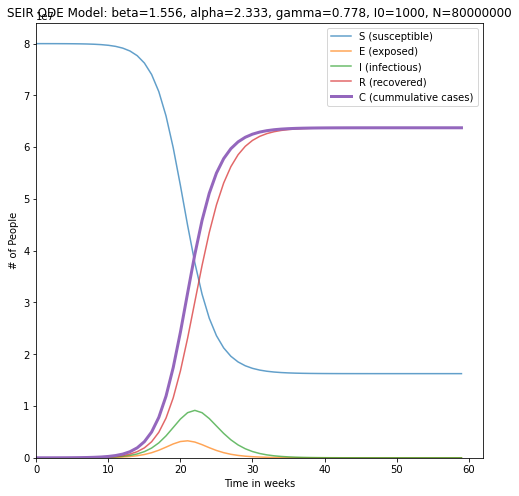

In [6]:
plot_seirc(params=[BETA, ALPHA, GAMMA, I_0], n=N, weeks=WEEKS)

## Latin Hypercube Sampling

In [7]:
#general implementation, independent from SEIR model
def latin_hypercube_uniform(dim, n_samples, low, high):
    if (len(low) != dim or len(high) != dim):
        raise Exception(f"{len(low)} low and {len(high)} high values given but should be {dim} values each")
    for l, h in zip(low, high):
        if (l >= h):
            raise Exception(f"Value for high ({h}) should be greater than value for low ({l})")

  
    #create array of shape(dim, n_samples) and transpose later.
    #This means all samples of one param are in one row vector which makes sampling easier
    arr = np.ndarray(shape=(dim, n_samples), dtype=float)
    rng = np.random.default_rng()
    
    for i in range(dim):
        subinterval_size = (high[i]-low[i])/n_samples
        
        arr[i] = np.linspace(low[i], high[i], n_samples, endpoint=False)
        #This is neccessary in multidimensional cases to create samples in the
        #entire space of the hypercube and not only on the diagonal
        np.random.shuffle(arr[i])
        
        for j in range(n_samples):
            arr[i][j] = rng.uniform(arr[i][j], arr[i][j] + subinterval_size)
    
    #Get back to the shape(n_samples, dim) so every line contains one param vector
    return arr.transpose()

### Verify LHS

In [8]:
def test_samples(samples, low, high) -> bool:
    dimension = len(low)
    interval_sizes = [(high[i] - low[i]) / len(samples) for i in range(dimension)]
    used_intervals = [[] for _ in range(dimension)]

    for sample in samples:
        for i in range(dimension):
            if low[i] < sample[i] > high[i]:
                print("Sample outside of boundaries")
                return False

            sample_interval = math.floor((sample[i] - low[i]) / interval_sizes[i])

            if sample_interval in used_intervals[i]:
                print(f"More then one sample found for dimension {i} in interval {i}")
                return False
            else:
                used_intervals[i].append(sample_interval)

    return True

In [9]:
low = [1, 0.5, 0.5, 500]
high = [3, 3.5, 1, 2500]
samples = latin_hypercube_uniform(4, 1000, low, high)
if test_samples(samples, low, high):
    print("Samples are correct")
else:
    raise Exception("Given Samples do not match requirements for LHS-sampled values")

Samples are correct


Test the exceptions thrown by LHS function

In [10]:
low = [1, 2]
high = [3, 4, 5]

try:
    latin_hypercube_uniform(4, 1000, low, high)
except Exception as e:
    print(f"got following exception: {e}")
else:
    raise Exception("Expected an exception since low and high values dont match with dimension")

got following exception: 2 low and 3 high values given but should be 4 values each


In [11]:
low = [10]
high = [5]

try:
    latin_hypercube_uniform(1, 1000, low, high)
except Exception as e:
    print(f"got following exception: {e}")
else:
    raise Exception("Expected an exception since low value is higher than high value")

got following exception: Value for high (5) should be greater than value for low (10)


## PCCs and PRCCs

In [12]:
#Helper function for partial_corrcoef()
def root_of_squared_sum(x):
    return np.sqrt(np.sum(x**2))

In [13]:
#To Calculate PRCCs calculate and pass the ranks instead of actual values as params
def partial_corrcoef(X, y):
    params = X.shape[1]
    samples = len(y)
    
    if X.shape[0] != len(y):
        raise Exception(f"Matrix x has %{X.shape[0]} rows but Vector y has size %{len(y)}")
    
    pccs = np.ndarray(shape=(params), dtype=float)
    #calc PCC for all params
    for i in range(params):
        #remove the samples of param X_i
        x_i = X.transpose()[i]
        A = np.delete(X, i, 1)
        A = np.vstack([A.T, np.ones(samples)]).T
        # Calc least square linear regressioon coefficients between X_i and other X
        w_x_i = np.linalg.lstsq(A, x_i, rcond=None)[0]
        # Calc least square linear regression coefficients between X_i and y
        w_y = np.linalg.lstsq(A, y, rcond=None)[0]
        
        x_i_residuals = np.ndarray(shape=(samples), dtype=float)
        y_residuals = np.ndarray(shape=(samples), dtype=float)      
        for j in range(samples):
            x_i_residuals[j] = x_i[j] - np.dot(w_x_i, A[j])
            y_residuals[j] = y[j] - np.dot(w_y, A[j])
            
        pccs[i] = (np.dot(x_i_residuals, y_residuals))/(root_of_squared_sum(x_i_residuals) * root_of_squared_sum(y_residuals))        
    return pccs

### PRCCs

In [14]:
def values_to_ranks(values):
    sorted_values = values.copy()
    sorted_values.sort()
    #ranks = np.ndarray(shape=(len(arr)), dtype=int)
    # searchsorted returns index of value v. Use side=right to get index+1 (rank).
    ranks = [sorted_values.searchsorted(v, side='right') for v in values]
    return np.array(ranks, dtype=int)

    

In [15]:
def rank_matrix(A):
    B = np.ndarray(shape=A.T.shape, dtype=int)
    # Transpose A for rank calc (get all samples of param x_i in one row vector)
    for i in range(len(B)):
        B[i] = values_to_ranks(A.T[i])
    #retranspose to get one param_vectors (x_1...x_4) in rows
    return B.T
        

In [16]:
def partial_rank_corrcoef(X, y):
    X_ranked = rank_matrix(X)
    y_ranked = values_to_ranks(y)
    prccs = partial_corrcoef(X_ranked, y_ranked)
    return prccs

### Verify PCC

In [17]:
# Take the table from page 16 from script 4.2 partial rank correlation coefficients and compare reference
# results with results from own calc

# sample two uniformly distributed independent random variables X1 and X2 
# X1, X2 ~ U([0,1])
samples = latin_hypercube_uniform(2, 10000, [0,0], [1,1])

# Y = X1 + X2  --> expect pccs of 1.0 
y = np.array([x1 + x2 for (x1, x2) in samples])
y1_pccs = partial_corrcoef(samples, y)
y1_prccs = partial_rank_corrcoef(samples, y)
print(f"PCCs for Y = X1 + X2 are {y1_pccs} and PRCCS are {y1_prccs}")
print(f"Reference values for PCCS are [1.0, 1.0] and for PRCCS [0.98, 0.98]\n")


# Y = X1 + X2^4  --> X1 should a bigger influence/correlation on/to Y than X2
y = np.array([x1 + (x2**4) for (x1, x2) in samples])
y2_pccs = partial_corrcoef(samples, y)
y2_prccs = partial_rank_corrcoef(samples, y)
print(f"PCCs for Y = X1 + X2^4 are {y2_pccs} and PRCCS are {y2_prccs}")
print(f"Reference values for PCCS are [0.91, 0.87] and for PRCCS [0.93, 0.86]\n")

        
# Y = X1 + cot(pi*X2)
y = np.array([x1 + 1/(np.tan(np.pi * x2)) for (x1, x2) in samples])
y3_pccs = partial_corrcoef(samples, y)
y3_prccs = partial_rank_corrcoef(samples, y)
print(f"PCCs for Y = X1 + cot(pi*X2) are {y3_pccs} and PRCCS are {y3_prccs}")
print(f"Reference values for PCCS are [-0.02, -0.06] and for PRCCS [0.82, -0.99]\n")


PCCs for Y = X1 + X2 are [1. 1.] and PRCCS are [0.97980268 0.9797909 ]
Reference values for PCCS are [1.0, 1.0] and for PRCCS [0.98, 0.98]

PCCs for Y = X1 + X2^4 are [0.90860263 0.86603676] and PRCCS are [0.91791863 0.85925808]
Reference values for PCCS are [0.91, 0.87] and for PRCCS [0.93, 0.86]

PCCs for Y = X1 + cot(pi*X2) are [-0.0095377  -0.08331544] and PRCCS are [ 0.82017365 -0.99406829]
Reference values for PCCS are [-0.02, -0.06] and for PRCCS [0.82, -0.99]



## Application of LHS and P(R)CCs to the SEIR Model

#### Sample values from Hypercube H by using Latin Hypercube Sampling

Hypercube: H = [1,3] x [7/14, 7/2] x [7/14, 7/7] x [500, 2500]

In [18]:
def sample_and_solve(num_samples):
    lhs_param_samples = latin_hypercube_uniform(len(PARAM_LOWS), num_samples, PARAM_LOWS, PARAM_HIGHS)
    np.save('lhs_params.npy', lhs_param_samples)
    lhs_solutions = [integrate_seirc(lhs_param_samples[i], N, WEEKS).y for i in range(len(lhs_param_samples))]
    np.save('lhs_solutions.npy', lhs_solutions)

In [19]:
#Call this function manually to sample new parameters and therefore get new solutions to the SEIR model.
#Otherwise the samples stored in lhs_params.npy will be used

#sample_and_solve(SAMPLES)

In [20]:
#Check if param and solution file exists - if not create them by sampling params and calculate solution
try:
    f = open("lhs_params.npy")
    f = open("lhs_solutions.npy")
except FileNotFoundError:
    # Create solutions file by sampling parameters and solve seir model for them
    print("Sampling params and creating lhs_solutions.npy ...")
    sample_and_solve(SAMPLES)
finally:
    f.close()

#### Get QoIs from the solutions

In [21]:
def get_final_cumulative_cases(solution_file="lhs_solutions.npy"):
    solutions = np.load(solution_file)
    final_c = np.array([solutions[i][4][-1] for i in range(len(solutions))]) 
    return final_c

In [22]:
def get_peak_infections_week(solution_file="lhs_solutions.npy"):
    solutions = np.load(solution_file)
    infections = np.array([solutions[i][2] for i in range(len(solutions))])
    peak_inf = np.argmax(infections, axis=1)
    return peak_inf

#### Calculate PRCCs between input parameters and final cumulative cases

In [23]:
def cum_cases_prccs():
    final_cum_cases = get_final_cumulative_cases()
    params = np.load('lhs_params.npy')
    prccs = partial_rank_corrcoef(params, final_cum_cases)
    return prccs

prccs are: 0.98 for beta, 0.10 for alpha, -0.96 for gamma and 0.02 for I0


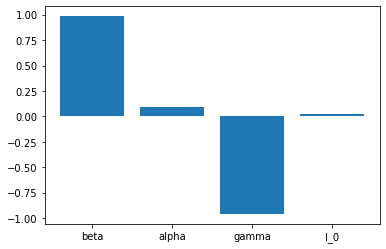

In [24]:
prccs = cum_cases_prccs()
print(f'prccs are: {prccs[0]:.2f} for beta, {prccs[1]:.2f} for alpha, {prccs[2]:.2f} for gamma and {prccs[3]:.2f} for I0')
plt.bar(['beta', 'alpha', 'gamma', 'I_0'], prccs)
plt.show()

#### Calculate PRCCs between input parameters and week of peak infection

In [25]:
def peak_infections_prccs():
    peak_infections = get_peak_infections_week()
    params = np.load('lhs_params.npy')
    prccs = partial_rank_corrcoef(params, peak_infections)
    return prccs

prccs are: -0.97 for beta, -0.88 for alpha, 0.72 for gamma and -0.35 for I0


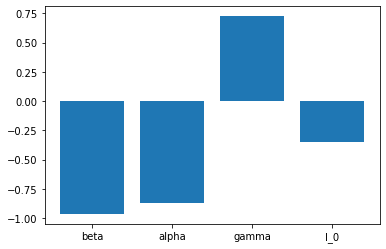

In [26]:
prccs = peak_infections_prccs()
print(f'prccs are: {prccs[0]:.2f} for beta, {prccs[1]:.2f} for alpha, {prccs[2]:.2f} for gamma and {prccs[3]:.2f} for I0')
plt.bar(['beta', 'alpha', 'gamma', 'I_0'], prccs)
plt.show()
